# Motivating Coding Example

From Richard Caruana's thesis paper on Multi-task learning 

## Tasks

* Task 1 = $B1      \vee Parity(B4-B8)$
* Task 2 = $\neg(B1) \vee  Parity(B4-B8)$
* Task 3 = $B1      \wedge Parity(B4-B8)$
* Task 4 = $\neg(B1) \wedge Parity(B4-B8)$

example

input: 10100101

Task 1: $B1 == 1 \vee Parity(B4-B8) \rightarrow B1 == 1 \rightarrow Task1 = True$

Task 2: $B1 == 0 \vee Parity(B4-B8) \rightarrow B1 !=0 \rightarrow Parity(B2-B8) = 2 \rightarrow Task 2 = True$

Task 3: $B1 == 1 \wedge Parity(B4-B8) \rightarrow True \wedge True \rightarrow Task 3 = True$

Task 4: $B1 == 1 \rightarrow Task 4 = False$

### shared information between tasks

We can see that there is shared information between tasks, for example Task 1 and Task 2 are both true (false) if the Parity of bits 4 through 8 is true (false). likewise task 3 and 4 are both false if the parity of bits 4 through 8 are false. Another signal we are hoping that is learned is to ignore bits 2 and 3.



In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from make_targets import getParity, get_data
from model_training import train_model, test_model
import os

################################################################################################################################
# DATASETS

class BinaryDataset(Dataset):

    def __init__(self, filename):
        # data loading
        df = pd.read_csv(filename) # bits 3, 4 don't matter
        X = []
        for i in range(256):
            X.append([int(i) for i in str(format(i, '08b'))])

        self.x = torch.FloatTensor(X)
        self.y1 = torch.transpose(torch.FloatTensor([df['1'].to_numpy()]), 0, 1)
        self.y2 = torch.transpose(torch.FloatTensor([df['2'].to_numpy()]), 0, 1)
        self.y3 = torch.transpose(torch.FloatTensor([df['3'].to_numpy()]), 0, 1)
        self.y4 = torch.transpose(torch.FloatTensor([df['4'].to_numpy()]), 0, 1) 
        self.num_samples = self.x.shape[0]


    def __getitem__(self, index):
        return self.x[index], self.y1[index], self.y2[index], self.y3[index], self.y4[index]

    def __len__(self):
        return self.num_samples

################################################################################################################################
# MODEL CLASSES

class MultiTask(nn.Module):

    def __init__(self, num_targets):
        super(MultiTask, self).__init__()
        self.hidden1 = nn.Linear(8, 100)  # 8 input units 100 hidden units
        self.hidden2 = nn.Linear(100, 20)
        self.output = nn.Linear(20, num_targets)    # 1 output
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))         # relu activation function for hidden layers
        x = F.relu(self.hidden2(x)) 
        x = torch.sigmoid(self.output(x))   # sigmoid returns probability of being 1
        return x  

    
################################################################################################################################
# IMPORT DATA

# format and shuffle data
dataset = BinaryDataset('./targets2.csv')
dataset_size = len(dataset)
valid_split = 0.5
random_seed = 46

# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(valid_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(train_sampler), 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=len(valid_sampler),
                                                sampler=valid_sampler)
dataloaders = [train_loader, validation_loader]


# Training Procedure

## Hyper Parameters

* Train/Test split = .5/.5  

* Epochs = 15000

* Optimizer = SGD (stochastic gradient decent)

* learning rate = 0.1

* Loss Function = Binary Cross Entropy Loss

$\mathrm{Loss} = - \frac{1}{\mathrm{output \atop size}} \sum_{i=1}^{\mathrm{output \atop size}} y_i \cdot \mathrm{log}\; {\hat{y}}_i + (1-y_i) \cdot \mathrm{log}\; (1-{\hat{y}}_i)\$

For each test case (below) we will train and test 5 models on different random shuffles of the data and report the average test accruacy over those 5 models. we are only testing on target 1 and are using all other targets as auxilary tasks to hopefully generalize the model learned.

All models use the same hyper parameters and layer configuration


###  STL

### MTL tasks 1 and 2

### MTL tasks 1 and 3 

### MTL tasks 1, 2, 3 and 4

--------------------------------------------------------------------------------------

# Results

[0.25976562 0.34960938 0.56640625 ... 0.79882812 0.79882812 0.79882812]
[0.5140625 0.546875  0.5703125 ... 0.8796875 0.8796875 0.8796875]
[0.8453125 0.834375  0.8234375 ... 0.8953125 0.8953125 0.8953125]
[0.4640625 0.4796875 0.5125    ... 0.903125  0.903125  0.903125 ]


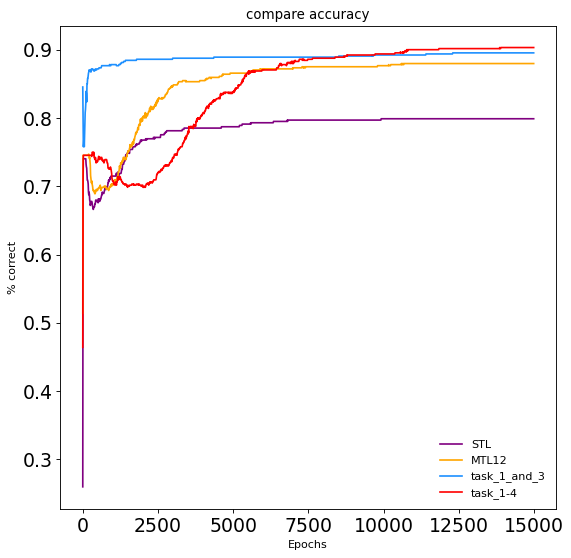

In [7]:
# load average test on target 1
STL = np.load('./models1/average1.npy')
MTL12 = np.load('./models1/average12.npy')
MTL13 = np.load('./models1/average13.npy')
MTL14 = np.load('./models1/average14.npy')

print(STL)
print(MTL12)
print(MTL13)
print(MTL14)

# X axis for graph
x = [i for i in range(15000)]
x = x[::10]

# Make Graph
plt.figure(figsize=(8, 8), dpi=80)
plt.title("compare accuracy")
plt.plot(x, STL[::10], label="STL", color='purple', linewidth=1.5)
plt.plot(x, MTL12[::10], label="MTL12", color="orange", linewidth=1.5)
plt.plot(x, MTL13[::10], label="task_1_and_3", color='dodgerblue', linewidth=1.5)
plt.plot(x, MTL14[::10], label="task_1-4", color='red', linewidth=1.5)
plt.legend(frameon=False, prop={'size': 22})
plt.xlabel('Epochs')
plt.ylabel('% correct') 
plt.legend(frameon=False)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.show()


# Negative Transfer?? 

If tasks are not related, training signal can actually hurt our accuracy on our goal task

## Tasks

* Task 1 = $B1      \vee Parity(B2-B8)$
* Task 2 = $\neg(B1) \vee  Parity(B2-B8)$
* Task 3 = $B1      \wedge Parity(B2-B8)$
* Task 4 = $\neg(B1) \wedge Parity(B2-B8)$

only thing changed is we are now looking at parity bits 2-8 instead of bits 4-8


[0.5234375  0.609375   0.75       ... 0.72265625 0.72265625 0.72265625]
[0.5046875 0.56875   0.678125  ... 0.9625    0.9625    0.9625   ]
[0.8015625 0.8046875 0.8078125 ... 0.8078125 0.8078125 0.8078125]
[0.5421875 0.565625  0.590625  ... 0.6265625 0.6265625 0.6265625]


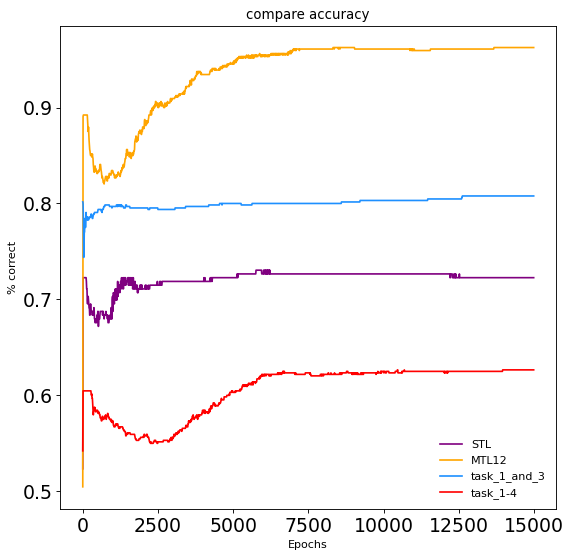

In [8]:
# load average test on target 1
STL = np.load('./models/average1.npy')
MTL12 = np.load('./models/average12.npy')
MTL13 = np.load('./models/average13.npy')
MTL14 = np.load('./models/average14.npy')

print(STL)
print(MTL12)
print(MTL13)
print(MTL14)

# X axis for graph
x = [i for i in range(15000)]
x = x[::10]

# Make Graph
plt.figure(figsize=(8, 8), dpi=80)
plt.title("compare accuracy")
plt.plot(x, STL[::10], label="STL", color='purple', linewidth=1.5)
plt.plot(x, MTL12[::10], label="MTL12", color="orange", linewidth=1.5)
plt.plot(x, MTL13[::10], label="task_1_and_3", color='dodgerblue', linewidth=1.5)
plt.plot(x, MTL14[::10], label="task_1-4", color='red', linewidth=1.5)
plt.legend(frameon=False, prop={'size': 22})
plt.xlabel('Epochs')
plt.ylabel('% correct') 
plt.legend(frameon=False)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.show()